In [ ]:
import numpy as np
from scipy.special import expit
import sys


# Implémentation du MLP
# Couche d'entrées, 1 couche cachée et couche de sorties
#
# Code similaire à Adaline

class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.Should be equal to the number of columns in the X array.
    n_hidden : list (default: [30])
        List containing the number of hidden units in each hidden layer. By default, a
        single hidden layer containing 30 units is used.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization. No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization. No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the gradient of the previous epoch t-1 to improve learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency. Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

    def __init__(self, n_output, n_features, n_hidden=[30], l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0,
                 decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.weights, self.biases = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]   Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        
        #for idx, val in enumerate(y):
        #    onehot[val, idx] = 1.0

        onehot[y, np.arange(y.shape[0])] = 1

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        weights = []
        biases = []

        # Weights of the hidden layers and output layers
        prev = self.n_features

        for i, h in enumerate(self.n_hidden + [self.n_output]):
            w = np.random.uniform(-1.0, 1.0, size=(h, prev))
            b = np.random.uniform(-1.0, 1.0, size=h)

            prev = h

            weights.append(w)
            biases.append(b)
            
        return weights, biases

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, weights, biases):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        # Memory of previous operations: list of tuples (z,a)
        forward = []

        # Transpose X (first layer)
        a = X.T
        forward.append((a,a)) # No 'z' for input layer

        # Apply layers
        for w, b in zip(weights, biases):
            # Net input: z^(i)
            z = w.dot(a) + b[:, None]

            # Activation: a^(i)
            a = self._sigmoid(z)
            
            # Append to memory
            forward.append((z,a))

        return forward

    def _L2_reg(self, lambda_, weights):
        """Compute L2-regularization cost"""
        return (lambda_ / 2.0) * sum(np.sum(w**2) for w in weights)

    def _L1_reg(self, lambda_, weights):
        """Compute L1-regularization cost"""
        return (lambda_ / 2.0) * sum(np.abs(w).sum() for w in weights)

    def _get_cost(self, y_enc, output, weights):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, weights)
        L2_term = self._L2_reg(self.l2, weights)
        cost = cost + L1_term + L2_term
        return cost

    #
    # Nous verrons plus tard
    #
    def _get_gradient(self, forward, y_enc, weights, biases):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        grad_w = []
        grad_b = []

        # Erreur de classification
        sigma = forward[-1][1] - y_enc

        for (z, a), w, b in zip(reversed(forward[:-1]), reversed(weights), reversed(biases)):
            # Compute gradient: sigma^(i+1) * [a^(i)]^T
            gw = sigma.dot(a.T)
            gb = sigma.sum(axis=1)

            # Regularize (not biases)
            gw += self.l2 * w
            gw += self.l1 * np.sign(w)

            # Append gradients
            grad_w.append(gw)
            grad_b.append(gb)

            # Update error to previous layer
            sigma = w.T.dot(sigma) * self._sigmoid_gradient(z)

        # Reverse gradients
        grad_w = [gw for gw in reversed(grad_w)]
        grad_b = [gb for gb in reversed(grad_b)]

        return grad_w, grad_b

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        forward = self._feedforward(X, self.weights, self.biases)
        y_pred = np.argmax(forward[-1][1], axis=0)
        return y_pred

    #
    # Fonction d'entraînement
    #
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)  # Vecteur one-hot

        delta_w_prev = [np.zeros(w.shape) for w in self.weights]
        delta_b_prev = [np.zeros(b.shape) for b in self.biases]

        for i in range(self.epochs):  # Nombre de passage sur le dataset
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const * i)  # Permet de réduire le nombre d'epochs nécessaire à la convergence en limitant les risques de "pas" trop grand!

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:  # on mélange le dataset à chaque epoch
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]),
                                  self.minibatches)  # Si le mode minibatch est activé, le dataset en entrée est divisé en batch pour le calcul des gradients
            for idx in mini:
                # feedforward
                forward = self._feedforward(X_data[idx], self.weights, self.biases)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=forward[-1][1], weights=self.weights)
                self.cost_.append(cost)

                # compute gradients via backpropagation
                grad_w, grad_b = self._get_gradient(forward, y_enc[:, idx], self.weights, self.biases)

                # Compute delta_w, delta_b
                delta_w = [self.eta * gw for gw in grad_w]
                delta_b = [self.eta * gb for gb in grad_b]

                # Update weights and biases
                for i, (dw, db) in enumerate(zip(delta_w, delta_b)):
                    self.weights[i] -= (dw + self.alpha * delta_w_prev[i])
                    self.biases[i] -= (db + self.alpha * delta_b_prev[i])
                
                # Keep previous weights and biases for momentum
                delta_w_prev = delta_w
                delta_b_prev = delta_b

        return self


In [89]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_train, y_train = load_mnist('Perceptron multicouches/data/MNIST/raw/', kind='train')
X_test, y_test = load_mnist('Perceptron multicouches/data/MNIST/raw/', kind='t10k')
X_train


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

In [90]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=[50],
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50,
                  shuffle=True,
                  random_state=1)


In [91]:
[w.shape for w in nn.weights]

[(50, 784), (10, 50)]

In [92]:
[b.shape for b in nn.biases]

[(50,), (10,)]

In [93]:
forward = nn._feedforward(X_test, nn.weights, nn.biases)
[(z.shape, a.shape) for (a,z) in forward]

[((784, 10000), (784, 10000)),
 ((50, 10000), (50, 10000)),
 ((10, 10000), (10, 10000))]

In [94]:
nn._L1_reg(0.001, nn.weights)

np.float64(9.941326555244498)

In [95]:
nn._L2_reg(0.001, nn.weights)

np.float64(6.632849671029394)

In [96]:
forward = nn._feedforward(X_test, nn.weights, nn.biases)
nn._get_cost(nn._encode_labels(y_test, 10), forward[-1][1], nn.weights)

np.float64(184137.53700336078)

In [97]:
grad_w, grad_b = nn._get_gradient(forward, nn._encode_labels(y_test, 10), nn.weights, nn.biases)

In [98]:
[gw.shape for gw in grad_w]

[(50, 784), (10, 50)]

In [99]:
[gb.shape for gb in grad_b]

[(50,), (10,)]

In [100]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1/1000

Epoch: 1000/1000

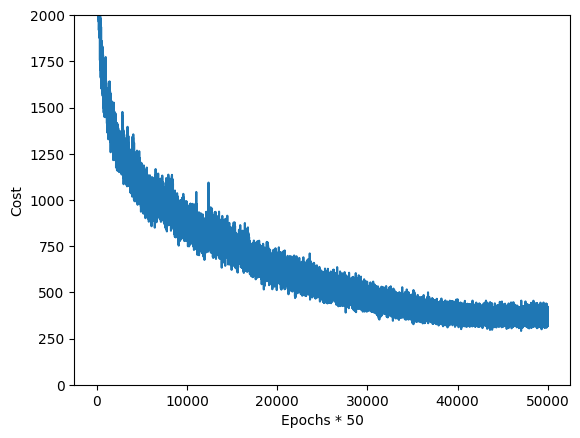

In [101]:
fig, ax = plt.subplots()

ax.plot(range(len(nn.cost_)), nn.cost_)
ax.set_ylim([0, 2000])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs * 50')
fig.savefig('./figures/cost.png', dpi=300, bbox_inches="tight")


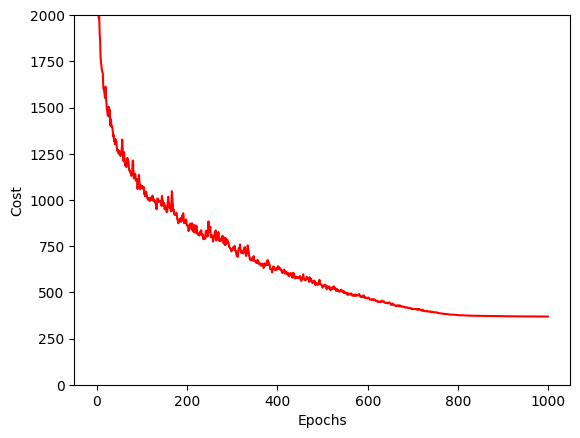

In [102]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

fig, ax = plt.subplots()
ax.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax.set_ylim([0, 2000])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')
fig.savefig('./figures/cost2.png', dpi=300, bbox_inches="tight")

In [103]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.68%
Test accuracy: 96.08%


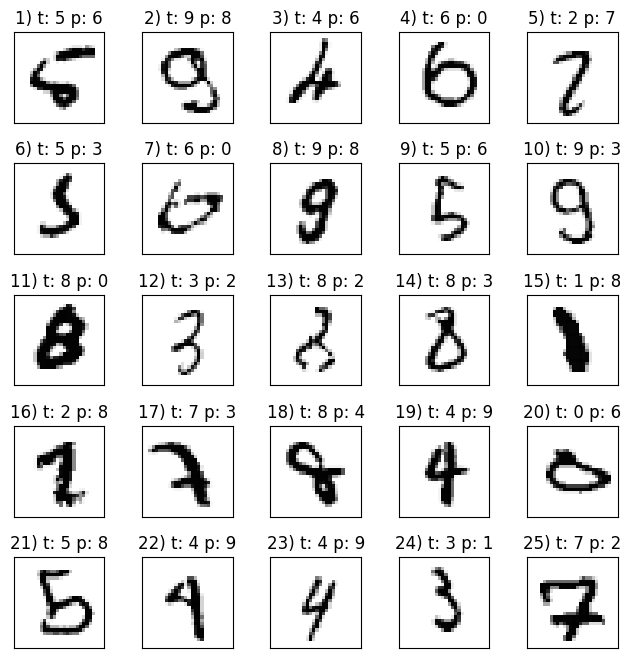

In [104]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,8))
fig.subplots_adjust(hspace=0.45)
axes = axes.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    axes[i].imshow(img, cmap='Greys', interpolation='nearest')
    axes[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

axes[0].set_xticks([])
axes[0].set_yticks([])

fig.savefig('./figures/mnist_miscl.png', dpi=300, bbox_inches="tight")

